# Booking

This notebook is an example on how to use the Vertica ML Python Library. We will use the Expedia dataset to predict if a user click will lead to a booking. You can download the Jupyter Notebook of the study by clicking <a href="booking.ipynb">here</a>. You can download the dataset by clicking <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">here</a>. To achieve our goals, we have access to the following data.

<ul class="ul_elem">
    <li><b>cnt: </b>Number of similar events in the context of the same user session.</li>
    <li><b>user_location_city: </b>The ID of the city the customer is located.</li>
    <li><b>is_package: </b>1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise.</li>
    <li><b>user_id: </b>ID of user.</li>
    <li><b>srch_children_cnt: </b>The number of (extra occupancy) children specified in the hotel room.</li>
    <li><b>channel: </b>ID of a marketing channel.</li>
    <li><b>hotel_cluster: </b>ID of a hotel cluster.</li>
    <li><b>srch_destination_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>is_mobile: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>srch_adults_cnt: </b>The number of adults specified in the hotel room.</li>
    <li><b>user_location_country: </b>The ID of the city the customer is located.</li>
    <li><b>srch_destination_type_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>srch_rm_cnt: </b>The number of hotel rooms specified in the search.</li>
    <li><b>posa_continent: </b>ID of continent associated with site_name.</li>
    <li><b>srch_ci: </b>Checkin date.</li>
    <li><b>user_location_region: </b>The ID of the region the customer is located.</li>
    <li><b>hotel_country: </b>Hotel country.</li>
    <li><b>srch_co: </b>Checkout date.</li>
    <li><b>is_booking: </b>1 if a booking, 0 if a click.</li>
    <li><b>orig_destination_distance: </b>Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated.</li>
    <li><b>hotel_continent: </b>Hotel continent.</li>
    <li><b>site_name: </b>ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...).</li>
</ul>
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from vertica_ml_python import *
expedia = vDataframe('expedia')
expedia.head(5)

,cnt,user_location_city,is_package,user_id,srch_children_cnt,channel,hotel_cluster,srch_destination_id,is_mobile,srch_adults_cnt,user_location_country,srch_destination_type_id,srch_rm_cnt,posa_continent,srch_ci,date_time,hotel_market,hotel_country,srch_co,is_booking,orig_destination_distance,hotel_continent,site_name,user_location_region
0,1,5703,0,461899,1,9,41,669,0,2,3,3,1,2,2013-03-14,2013-01-07 00:00:02,212,50,2013-03-15,0,None,2,24,50
1,3,21177,0,13796,0,9,58,8821,0,1,66,1,1,3,2013-01-19,2013-01-07 00:00:06,30,17,2013-01-26,0,5713.62060,6,2,174
2,1,14703,0,1128575,0,9,91,25064,0,1,205,6,1,3,2013-01-19,2013-01-07 00:00:06,1230,50,2013-01-22,0,795.72980,2,11,155
3,2,41949,0,1018895,0,0,59,27215,0,2,69,6,1,1,2013-09-08,2013-01-07 00:00:17,645,50,2013-09-10,0,None,2,37,761
4,2,18767,0,783725,3,9,48,8855,1,3,66,1,1,3,2013-07-29,2013-01-07 00:00:18,213,50,2013-08-04,0,2696.50030,2,2,462
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia, Number of rows: 37670293, Number of columns: 24

## Data Exploration and Preparation

Analysing user activity is crucial to understand why he/she books. Sessionization is the process of gathering clicks for a certain period of time. We usually consider that after 30 minutes of inactivity, the user session ends (date_time - lag(date_time) > 30 minutes). For this kind of use cases, aggregating sessions with meaningful statistics is the key to do correct predictions.

In [2]:
expedia.sessionize(ts = "date_time", 
                   by = ["user_id"], 
                   session_threshold = "30 minutes", 
                   name = "session_id")

,cnt,user_location_city,is_package,user_id,srch_children_cnt,channel,hotel_cluster,srch_destination_id,is_mobile,srch_adults_cnt,user_location_country,srch_destination_type_id,srch_rm_cnt,posa_continent,srch_ci,date_time,hotel_market,hotel_country,srch_co,is_booking,orig_destination_distance,hotel_continent,site_name,user_location_region,session_id
0,1,9045,0,0,2,2,19,24693,1,2,66,6,1,3,2014-09-06,2014-09-03 08:18:41,1241,50,2014-09-07,0,53.60590,2,2,174,0
1,1,42538,0,0,1,2,98,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:11,1230,50,2014-12-30,0,343.78660,2,2,174,1
2,1,42538,0,0,1,2,40,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:58,1230,50,2014-12-30,0,343.99010,2,2,174,1
3,1,42538,0,0,1,2,56,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:30:21,1230,50,2014-12-30,0,343.79680,2,2,174,1
4,2,42538,0,0,2,2,72,8279,1,3,66,1,1,3,2014-12-29,2014-12-03 11:32:43,358,50,2014-12-30,0,342.21630,2,2,174,1
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia, Number of rows: 37670293, Number of columns: 25

By using the method 'sessionize', we are able to create the 'session_id' which will be used to aggregate the data.

A very important feature could be the trip duration. It will probably influence the way the user will behave during the session.

In [3]:
expedia.eval("trip_duration", 
             "DATEDIFF(DAY, srch_ci, srch_co)")

,cnt,user_location_city,is_package,user_id,srch_children_cnt,channel,hotel_cluster,srch_destination_id,is_mobile,srch_adults_cnt,user_location_country,srch_destination_type_id,srch_rm_cnt,posa_continent,srch_ci,date_time,hotel_market,hotel_country,srch_co,is_booking,orig_destination_distance,hotel_continent,site_name,user_location_region,session_id,trip_duration
0,1,9045,0,0,2,2,19,24693,1,2,66,6,1,3,2014-09-06,2014-09-03 08:18:41,1241,50,2014-09-07,0,53.60590,2,2,174,0,1
1,1,42538,0,0,1,2,98,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:11,1230,50,2014-12-30,0,343.78660,2,2,174,1,1
2,1,42538,0,0,1,2,40,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:58,1230,50,2014-12-30,0,343.99010,2,2,174,1,1
3,1,42538,0,0,1,2,56,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:30:21,1230,50,2014-12-30,0,343.79680,2,2,174,1,1
4,2,42538,0,0,2,2,72,8279,1,3,66,1,1,3,2014-12-29,2014-12-03 11:32:43,358,50,2014-12-30,0,342.21630,2,2,174,1,1
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia, Number of rows: 37670293, Number of columns: 26

Looking many times at the same hotel could also influence the prediction. It could be a sign that the user will book the hotel during the session.

In [4]:
expedia.analytic('mode', 
                 column = "hotel_cluster", 
                 by = ["user_id",
                       "session_id"], 
                 name = "mode_hotel_cluster",
                 add_count = True)

,cnt,user_location_city,is_package,user_id,srch_children_cnt,channel,hotel_cluster,srch_destination_id,is_mobile,srch_adults_cnt,user_location_country,srch_destination_type_id,srch_rm_cnt,posa_continent,srch_ci,date_time,hotel_market,hotel_country,srch_co,is_booking,orig_destination_distance,hotel_continent,site_name,user_location_region,session_id,trip_duration,mode_hotel_cluster,mode_hotel_cluster_count
0,1,42538,0,0,1,2,98,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:11,1230,50,2014-12-30,0,343.78660,2,2,174,1,1,98,1
1,2,42538,0,0,2,2,72,8279,1,3,66,1,1,3,2014-12-29,2014-12-03 11:32:43,358,50,2014-12-30,0,342.21630,2,2,174,1,1,98,1
2,1,42538,0,0,1,2,56,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:30:21,1230,50,2014-12-30,0,343.79680,2,2,174,1,1,98,1
3,1,42538,0,0,1,2,40,8279,1,2,66,1,1,3,2014-12-29,2014-12-03 11:28:58,1230,50,2014-12-30,0,343.99010,2,2,174,1,1,98,1
4,1,37449,0,1,1,2,20,62881,1,5,66,4,2,3,2014-11-07,2014-04-25 16:14:46,2052,98,2014-11-09,0,5405.48890,4,2,174,0,2,20,3
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia, Number of rows: 37670293, Number of columns: 28

We can now aggregate the session to get useful statistics.
<ul>
    <li><b>end_session_date_time :</b> Date Time when the session ends.</li>
    <li><b>session_duration :</b> Session Duration.</li>
    <li><b>is_booking :</b> 1 if the user booked during the session.</li>
    <li><b>trip_duration :</b> Trip Duration.</li>
    <li><b>orig_destination_distance :</b> Average of the Physical distance between the hotels and the customer.</li>
    <li><b>srch_family_cnt :</b> The number of people specified in the hotel room.</li>
</ul>

In [5]:
expedia = expedia.groupby(
      columns = ["user_id",
                 "session_id", 
                 "mode_hotel_cluster_count"], 
      expr = ["MAX(date_time) AS end_session_date_time",
              "DATEDIFF(SECOND, MIN(date_time), MAX(date_time)) AS session_duration",
              "MAX(is_booking) AS is_booking",
              "AVG(trip_duration) AS trip_duration",
              "AVG(orig_destination_distance) AS avg_distance",
              "SUM(cnt) AS nb_click_session",
              "APPROXIMATE_MEDIAN(srch_children_cnt + srch_adults_cnt) AS srch_family_cnt"])

Let's now look at the missing values.

In [6]:
expedia.count()

,count,percent
"""user_id""",12242331.0,100.0
"""session_id""",12242331.0,100.0
"""mode_hotel_cluster_count""",12242331.0,100.0
"""end_session_date_time""",12242331.0,100.0
"""session_duration""",12242331.0,100.0
"""is_booking""",12242331.0,100.0
"""nb_click_session""",12242331.0,100.0
"""srch_family_cnt""",12242331.0,100.0
"""trip_duration""",12226336.0,99.869
"""avg_distance""",7966565.0,65.074


<object>

Let's impute the missing values of avg_distance and trip_duration.

In [7]:
expedia["avg_distance"].fillna(method = "avg")
expedia["trip_duration"].fillna(method = "avg")

4275766 element(s) was/were filled
15995 element(s) was/were filled


,user_id,session_id,mode_hotel_cluster_count,end_session_date_time,session_duration,is_booking,trip_duration,avg_distance,nb_click_session,srch_family_cnt
0,0,0,1,2014-09-03 08:18:41,0,0,1.0,53.6059,1,4.0
1,0,1,1,2014-12-03 11:32:43,272,0,1.0,343.44745,5,3.0
2,0,2,1,2014-12-06 01:38:26,0,0,1.0,88.1489,1,4.0
3,1,0,3,2014-04-25 16:15:50,82,0,2.0,5405.5519,4,4.0
4,2,0,3,2014-01-27 13:54:07,3487,0,3.77777777777778,1847.26115380414,13,2.0
,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 12242331, Number of columns: 10

We can then look at the link between the variables. We will use spearman coefficient to get all the monotonic relationships.

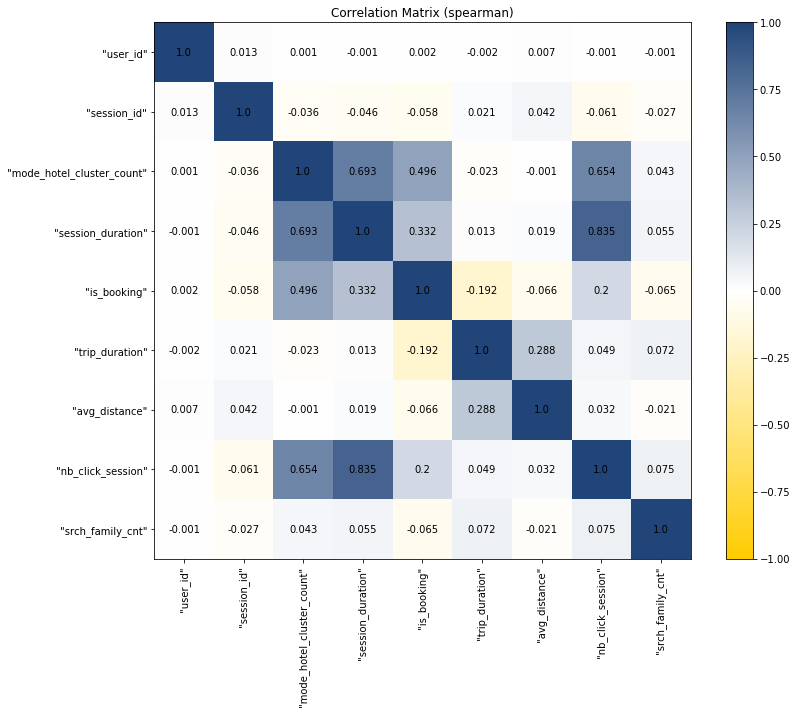

,"""user_id""","""session_id""","""mode_hotel_cluster_count""","""session_duration""","""is_booking""","""trip_duration""","""avg_distance""","""nb_click_session""","""srch_family_cnt"""
"""user_id""",1.0,0.0125372839769691,0.000585488528099556,-0.000541597877304615,0.00168318615437918,-0.00172294332358923,0.00722625140700152,-0.00130288969225954,-0.00145643651427301
"""session_id""",0.0125372839769691,1.0,-0.0362824718948203,-0.0456184717754819,-0.0579097807340728,0.0206225348881192,0.0424225822484464,-0.0614509659970033,-0.0267334768989548
"""mode_hotel_cluster_count""",0.000585488528099556,-0.0362824718948203,1.0,0.693149583808771,0.496196271565582,-0.0229387237074547,-0.00118724174477281,0.654237637118915,0.0430835831263844
"""session_duration""",-0.000541597877304615,-0.0456184717754819,0.693149583808771,1.0,0.331866631464122,0.0125253855406324,0.0188542087982699,0.834960977340327,0.0545771115310364
"""is_booking""",0.00168318615437918,-0.0579097807340728,0.496196271565582,0.331866631464122,1.0,-0.191911129719119,-0.0660072678069069,0.200140132943157,-0.0646466731033034
"""trip_duration""",-0.00172294332358923,0.0206225348881192,-0.0229387237074547,0.0125253855406324,-0.191911129719119,1.0,0.288326587959107,0.0494004219009955,0.0716986783665811
"""avg_distance""",0.00722625140700152,0.0424225822484464,-0.00118724174477281,0.0188542087982699,-0.0660072678069069,0.288326587959107,1.0,0.0322018254928665,-0.0205418178720803
"""nb_click_session""",-0.00130288969225954,-0.0614509659970033,0.654237637118915,0.834960977340327,0.200140132943157,0.0494004219009955,0.0322018254928665,1.0,0.0753040443807521
"""srch_family_cnt""",-0.00145643651427301,-0.0267334768989548,0.0430835831263844,0.0545771115310364,-0.0646466731033034,0.0716986783665811,-0.0205418178720803,0.0753040443807521,1.0


<object>

In [8]:
%matplotlib inline
expedia.corr(method = "spearman")

We can see huge links between some of the variables (mode_hotel_cluster_count & session_duration) and our response variable (is_booking). We can create a table of our dataset and use a Logistic Regression (it will work well thanks to the monotonic relationship between the response and the predictors).

In [9]:
drop_table("expedia_final")
expedia.to_db("expedia_final", 
              relation_type = "table", 
              inplace = True)

The table expedia_final was successfully dropped.


,avg_distance,user_id,nb_click_session,end_session_date_time,mode_hotel_cluster_count,session_duration,session_id,srch_family_cnt,is_booking,trip_duration
0,528.2537,326163,5,2014-10-13 09:05:00,2,224,33,2.0,1,1.0
1,943.4138,326163,2,2014-11-03 09:28:36,2,106,34,2.0,1,2.0
2,309.7657,326163,1,2014-11-09 21:06:26,1,0,35,2.0,0,1.0
3,377.2925,326163,3,2014-11-16 17:05:30,1,392,36,2.0,0,1.0
4,267.1483,326163,3,2014-11-18 15:52:09,2,260,37,2.0,1,1.0
,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia_final, Number of rows: 12242331, Number of columns: 10

## Machine Learning

Let's create our model.

In [10]:
drop_model("expedia_logit")

from vertica_ml_python.learn.linear_model import LogisticRegression
model_logit = LogisticRegression("expedia_logit", 
                                 max_iter = 1000, 
                                 solver = 'BFGS')
model_logit.fit("expedia_final", 
                ["avg_distance", 
                 "session_duration",
                 "nb_click_session",
                 "mode_hotel_cluster_count",
                 "session_id",
                 "srch_family_cnt",
                 "trip_duration"], 
                "is_booking")

The model expedia_logit was successfully dropped.




details
       predictor        |coefficient|std_err | z_value  |p_value 
------------------------+-----------+--------+----------+--------
       Intercept        | -1.60026  | 0.00272|-589.18481| 0.00000
      avg_distance      | -0.00004  | 0.00000|-78.24877 | 0.00000
    session_duration    |  0.00057  | 0.00000|381.52635 | 0.00000
    nb_click_session    | -0.16942  | 0.00030|-573.23360| 0.00000
mode_hotel_cluster_count|  1.13702  | 0.00112|1012.10490| 0.00000
       session_id       | -0.00574  | 0.00005|-109.11299| 0.00000
    srch_family_cnt     | -0.20740  | 0.00083|-250.59566| 0.00000
     trip_duration      | -0.24786  | 0.00048|-520.90693| 0.00000


regularization
type| lambda 
----+--------
 l2 | 1.00000


call_string
logistic_reg('public.expedia_logit', 'expedia_final', '"is_booking"', '"avg_distance", "session_duration", "nb_click_session", "mode_hotel_cluster_count", "session_id", "srch_family_cnt", "trip_duration"'
USING PARAMETERS optimizer='bfgs', epsilon=0.0001, m

None of our coefficients are rejected (pvalue = 0). Let's look at their importance.

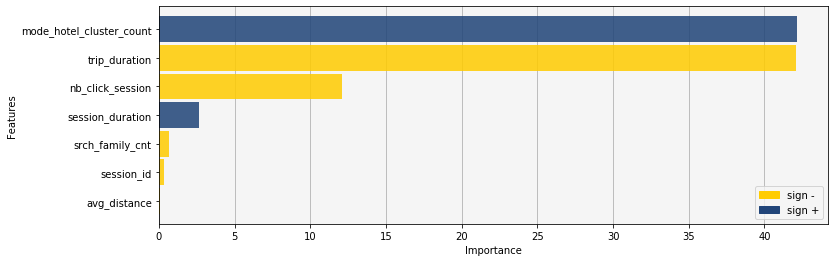

,importance
mode_hotel_cluster_count,42.12
trip_duration,42.1
nb_click_session,12.08
session_duration,2.64
srch_family_cnt,0.65
session_id,0.31
avg_distance,0.09


<object>

In [11]:
model_logit.features_importance()

It looks like there are 2 main predictors as expected (mode_hotel_cluster_count & trip_duration). According to the model, users who will probably book during the session are:
 - looking at the same hotel many times.
 - looking for a small trip duration.
 - not clicking too much (spending time at the same web page).

Let's add the prediction to our vDataFrame.

In [12]:
model_logit.predict(expedia, 
                    name = "booking_pred_logit", 
                    cutoff = -1.0)

,avg_distance,user_id,nb_click_session,end_session_date_time,mode_hotel_cluster_count,session_duration,session_id,srch_family_cnt,is_booking,trip_duration,booking_pred_logit
0,1847.26115380414,430510,1,2014-05-17 11:19:57,1,0,13,2.0,0,1.0,0.190557690545013
1,1847.26115380414,430510,4,2014-05-24 05:24:10,2,555,14,4.0,0,1.0,0.284096249561532
2,1847.26115380414,430510,3,2014-08-03 16:38:11,2,1343,15,2.0,0,1.0,0.524975355269267
3,1847.26115380414,430510,2,2014-08-26 16:16:18,2,156,16,2.0,0,2.0,0.341721838453188
4,1847.26115380414,430510,4,2014-11-21 16:25:41,1,194,17,2.0,0,2.0,0.10757616767729
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: expedia_final, Number of rows: 12242331, Number of columns: 11

We can analyze the following Boxplot (prediction partitioned by is_booking). We can notice that the cutoff is around 0.22 as most of the positive predictions have a probability between 0.23 and 0.5 whereas most of the negative predictions are between 0.05 and 0.2.

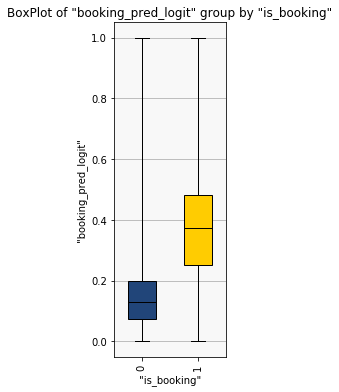

In [15]:
x = expedia["booking_pred_logit"].boxplot(by = "is_booking")

Let's confirm our hypothesis by computing the best cutoff.

In [16]:
model_logit.score(method = "best_cutoff")

0.22

Let's look at the efficiency of our model for this cutoff.

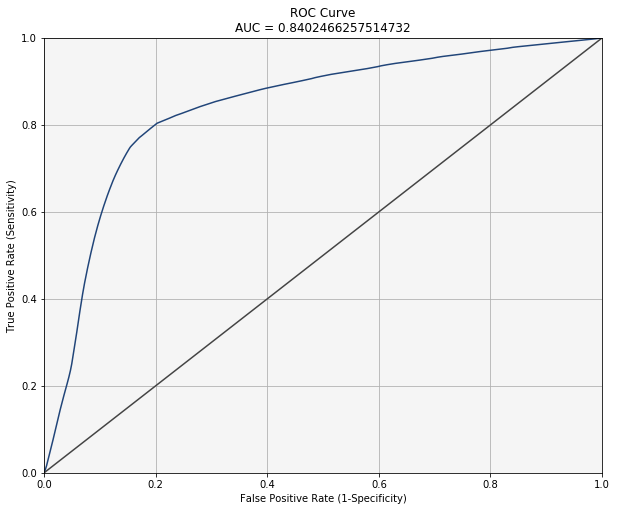

,value
auc,0.8402441872724233
prc_auc,0.5464609231559623
accuracy,0.80259257816179
log_loss,0.182579692727774
precision,0.7973002215815468
recall,0.5306353247809245
f1_score,0.6769167635528127
mcc,0.528906638236192
informedness,0.46518017980303306
markedness,0.6013631795076884


<object>

In [17]:
model_logit.roc_curve()
model_logit.classification_report(cutoff = 0.22)

Waw ! Our model is very good. We can predict if a user will book or not a hotel during a specific session. For example, it can be used to influence the user decision during the session by proposing new hotels or to target again the model false positives.

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.